In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import itertools
import math
import numbers
from sklearn.model_selection import train_test_split

from iisignature import *
from scipy.spatial import distance
plt.style.use("default")

import warnings
warnings.filterwarnings('ignore')

### Conformance anomlay detection equations

In [9]:
# Conformance anomaly detection method with signature transform
def sign_splitdata_train(x,y,order):
    signa = [list(sig(stream, order)) for stream in x]
    
    scaler = MinMaxScaler()
    X_center = np.array(scaler.fit_transform(signa))
    X1,X2,y1,y2 = train_test_split(X_center,y,test_size=0.5,random_state=10)
    
    return X1,X2,y1,y2

def conformance(x, X2):
    cov_X2 = np.linalg.pinv(np.cov((x-X2).T))
    inf = distance.mahalanobis(x, X2[0], cov_X2)
    for i in range(len(X2)):
        mal = distance.mahalanobis(x, X2[i], cov_X2)
        if inf > mal:
            inf = mal
    return inf

def thershold_all(X1,X2,epsilon):
    threshold_1,pred_label_1 = thershold(X1,X2,epsilon)
    threshold_2,pred_label_2 = thershold(X2,X1,epsilon)
    return (threshold_1+threshold_2)/2,pred_label_1,pred_label_2

def thershold(X1,X2,epsilon):
    dist = []
    pred_label = []
    for i in range(len(X1)):
        dist.append(conformance(X1[i],X2))
    dist = np.array(dist)
    threshold = np.quantile(dist,epsilon)
    
    for i in range(len(X1)):
        if dist[i] > threshold:
            dist = np.array(dist)
            pred_label.append(1)
        else:
            pred_label.append(0)
    return threshold,pred_label

def pred_anomaly(X_test,X2,thresh):
    predlabel = []
    conf = []
    for i in range(len(X_test)):
        conf.append(conformance(X_test[i],X2))
        if conf[i] > thresh:
            predlabel.append(1)
        else:
            predlabel.append(0)
    return conf,predlabel

# cited from https://github.com/crispitagorico/sigkernel/blob/master/sigkernel/transformers.py
import copy
import math
from scipy.ndimage import shift
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import as_float_array
def transform(paths, at=False, ll=False, scale=1.):
    #paths = scale*paths
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
    return np.array(paths)

def normalize(sigs, width, depth):
    new_sigs = []
    for sig in sigs:
        new_sig = np.zeros_like(sig)
        for k in range(depth):
            dim = width*(width**(k)-1)
            new_sig[dim:dim + width**(k+1)] = math.factorial(k+1)*sig[dim:dim + width**(k+1)]
        new_sigs.append(new_sig)
    return np.array(new_sigs)

class AddTime(BaseEstimator, TransformerMixin):
    def __init__(self, init_time=0., total_time=1.):
        self.init_time = init_time
        self.total_time = total_time

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        t = np.linspace(self.init_time, self.init_time + 1, len(X))
        return np.c_[t, X]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

class Reversion(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [as_float_array(x[::-1]) for x in X]


class LeadLag(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        lag = []
        lead = []

        for val_lag, val_lead in zip(X[:-1], X[1:]):
            lag.append(val_lag)
            lead.append(val_lag)

            lag.append(val_lag)
            lead.append(val_lead)

        lag.append(X[-1])
        lead.append(X[-1])

        return np.c_[lag, lead]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

### Read OB

In [10]:
# month_train = ['JAN','FEB','MAR',"APR","MAY"]
# month_test = ["JUN","JUL","AUG"]
month = ['JAN','FEB','MAR',"APR"]
def read_OB(coin,ttype):
    OB_all = pd.read_csv("../data/{}/{}USD_Gemini_OB_data_{}2020.csv".format(coin,coin,ttype[0]))
    for m in ttype[1:]:
        OB_month  = pd.read_csv("../data/{}/{}USD_Gemini_OB_data_{}2020.csv".format(coin,coin,m))
        frames = [OB_all, OB_month]
        OB_all = pd.concat(frames)
    return OB_all

### Normlized and label by hour

In [11]:
def creat_ob(OB_raw):
    OB_rawgroup = OB_raw.groupby(['date','side']).agg({'price':['first','last'], 'amount':['first','last']})
    
    OB_raw_date = OB_raw.date.unique()
    # OB_raw_date = pd.to_datetime(BTC_OB_raw.loc[:,'date'].unique()).date
    OB_raw_askprice = np.array(OB_rawgroup[('price', 'first')][0::2].reset_index(drop = True))
    OB_raw_askorder = np.array(OB_rawgroup[('amount', 'first')][0::2].reset_index(drop = True))
    OB_raw_bidprice = np.array(OB_rawgroup[('price', 'last')][1::2].reset_index(drop = True))
    OB_raw_bidorder = np.array(OB_rawgroup[('amount', 'last')][1::2].reset_index(drop = True))
    OB = pd.DataFrame({'datetime' : OB_raw_date,'best_ask_price' : OB_raw_askprice,'ask_order' : OB_raw_askorder, 'best_bid_price' : OB_raw_bidprice, 'bid_order' : OB_raw_bidorder})
    OB['datetime'] = pd.to_datetime(OB['datetime'])    # loop through hours

    return OB

In [12]:
def create_trans_ob(OB):
    OB['log_mid_price'] = np.log((OB['best_ask_price']+OB['best_bid_price'])/2)
    OB['spread'] = OB['best_ask_price']-OB['best_bid_price']
    OB['imbalance'] = (OB['ask_order'] - OB['bid_order'])
    #OB['imbalance'] = (OB['ask_order'] - OB['bid_order'])/(OB['ask_order'] + OB['bid_order'])
    return OB

In [13]:
def count_consec(lis):
    count=1
    consec_list=[]
    for i in range(len(lis[:-1])):
        if lis[i] == lis[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1  
        
    consec_list.append(count)   
        
    return consec_list

In [14]:
def separ_ob_bydate_dropdate(df_order_book):
    # date_column_index = df_order_book.groupby(by=df_order_book['datetime'].dt.date).agg({'datetime' : 'count'}).datetime.tolist()
    date_column_index = count_consec(df_order_book['datetime'].dt.date.tolist())
    date_label = df_order_book.datetime.dt.date.unique()
    scaler = MinMaxScaler()
    #df_order_book['datetime'] = scaler.fit_transform(df_order_book['datetime'].values.reshape(-1, 1))
    df_order_book.drop(columns =['datetime'],inplace=True)
    ob_total = []
    line_count = 0
    for i in range(len(date_column_index)):
        ob_eachdate = []
        for line in range(date_column_index[i]):
            ob_eachdate.append(df_order_book.iloc[line_count,:].to_numpy())
            line_count = line_count + 1
    
        ob_total.append(np.array(ob_eachdate))
    ob_total = np.array(ob_total)
    return ob_total,date_label

In [15]:
def OB_conformance_anomaly_detect_trainrepeat(OB_trans,epslion):
    BTC_OB_day_list,BTC_OB_day_label = separ_ob_bydate_dropdate(OB_trans)
    BTC_OB_day_list_ll = transform(np.array(BTC_OB_day_list),False,True)
    anoml_date_list = []
    
    date_X1,date_X2,date_y1,date_y2= sign_splitdata_train(BTC_OB_day_list_ll,BTC_OB_day_label,3)
    date_threshold,date_predlabel_1,date_predlabel_2 = thershold_all(date_X1,date_X2,epslion)
    
    for i in range(len(date_predlabel_1)):
        if date_predlabel_1[i] == 1:
            anoml_date_list.append(date_y1[i])
    for i in range(len(date_predlabel_2)):
        if date_predlabel_2[i] == 1:
            anoml_date_list.append(date_y2[i])
    
    return anoml_date_list,date_threshold

In [16]:
def OB_conformance_anomaly_detect_traintest(OB_train,OB_test,epslion):
    OB_value_train,OB_label_train = separ_ob_bydate_dropdate(OB_train)
    OB_value_test,OB_label_test = separ_ob_bydate_dropdate(OB_test)
    
    OB_day_list_train_ll = transform(np.array(OB_value_train),False,True)
    OB_day_list_test_ll = transform(np.array(OB_value_test),False,True)
    
    anoml_date_list_train = []
    anoml_date_list_test = []
    
    date_X1,date_X2,date_y1,date_y2,date_Xtest,data_Xtrain= sign_splitdata_all(OB_day_list_train_ll,OB_label_train,OB_day_list_test_ll,3)
    date_threshold,date_predlabel_train1,date_predlabel_train2= thershold_all(date_X1,date_X2,epslion)
    
    date_preddist_test,date_predlabel_test = pred_anomaly(date_Xtest,data_Xtrain,date_threshold)
    
    for i in range(len(date_predlabel_train1)):
        if date_predlabel_train1[i] == 1:
            anoml_date_list_train.append(date_y1[i])
    for i in range(len(date_predlabel_train2)):
        if date_predlabel_train2[i] == 1:
            anoml_date_list_train.append(date_y2[i])
            
    for i in range(len(date_predlabel_test)):
        if date_predlabel_test[i] == 1:
            anoml_date_list_test.append(OB_label_test[i])
    
    return anoml_date_list_train,anoml_date_list_test

In [17]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [18]:
# from sklearn.preprocessing import StandardScaler
# def implement_onlytrain(OB_name,OB_raw,epsilon):
#     OB = creat_ob(OB_raw)

#     OB_datetime = OB['datetime']

#     OB_trans = create_trans_ob(OB)
#     OB_trans = OB_trans.drop(columns=['best_ask_price', 'best_bid_price','ask_order','bid_order'])
    
#     OB_log_mid_price = OB_trans['log_mid_price']
#     OB_spread = OB_trans['spread']
    
    
#     anoml_date_train,threshold = OB_conformance_anomaly_detect_trainrepeat(OB_trans,epsilon)
    
#     fig, ax = plt.subplots(figsize=(12,5))
#     ax.plot(OB_datetime,OB_log_mid_price,label='log_mid_price_train',color = 'black')
    
#     for i in anoml_date_train:
#         ax.axvline(i,color = 'red',label='anomaly date',linewidth = 3,alpha =0.7)
#     legend_without_duplicate_labels(ax)
#     ax.set_ylabel('USD')
#     fig.savefig('figure/orderbook/market_{}_mid_price_train.png'.format(OB_name), dpi=300)
    
#     fig, ax = plt.subplots(figsize=(12,5))
#     ax.plot(OB_datetime,OB_spread,label='spread_train',color = 'black')
#     for i in anoml_date_train:
#         ax.axvline(i,color = 'red',label='anomaly date',linewidth = 3,alpha =0.7)
#     legend_without_duplicate_labels(ax)
#     ax.set_ylabel('USD')
#     fig.savefig('figure/orderbook/market_{}_spread_train.png'.format(OB_name), dpi=300)
    
#     return anoml_date_train,threshold

In [19]:
def plot_CADSig_result(OB_name,OB_raw,epsilon):
    OB = creat_ob(OB_raw)

    OB_datetime = OB['datetime']

    OB_trans = create_trans_ob(OB)
    
    min_max_scaler = MinMaxScaler()
    OB_scaled = min_max_scaler.fit_transform(OB_trans[['log_mid_price','spread','ask_order','bid_order']])
    OB_log_mid_price = OB_scaled.T[0]
    OB_spread = OB_scaled.T[1]
    OB_ask_order = OB_scaled.T[2]
    OB_bid_order = OB_scaled.T[3]
    
    OB_trans = OB_trans.drop(columns=['best_ask_price', 'best_bid_price','ask_order','bid_order'])

#     min_max_scaler = MinMaxScaler()
#     OB_scaled = min_max_scaler.fit_transform(OB_trans[['log_mid_price','spread']])
#     OB_log_mid_price = OB_scaled.T[0]
#     OB_spread = OB_scaled.T[1]

    
    anoml_date_train,threshold = OB_conformance_anomaly_detect_trainrepeat(OB_trans,epsilon)
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(OB_datetime,OB_log_mid_price,label='Log_mid_price',color=sns.color_palette('Set2')[2],alpha =0.7)
    ax.plot(OB_datetime,OB_spread,label='Spread',color=sns.color_palette('Set2')[3],alpha =0.7)
    ax.plot(OB_datetime,OB_ask_order,label='Ask_order',color=sns.color_palette('Set2')[4],alpha =0.7)
    ax.plot(OB_datetime,OB_bid_order,label='Bid_order',color =sns.color_palette('Set2')[6],alpha =0.7)
    
    for i in anoml_date_train:
        ax.axvline(i,color = 'red',label='anomaly date',linewidth = 3,alpha =0.3)
    legend_without_duplicate_labels(ax)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_ylabel('Standardize Value')
    fig.savefig('figure/orderbook/market_{}_mid_price_train.png'.format(OB_name), dpi=300)
    
#     fig, ax = plt.subplots(figsize=(12,5))
#     ax.plot(OB_datetime,OB_spread,label='spread_train',color = 'black')
#     for i in anoml_date_train:
#         ax.axvline(i,color = 'red',label='anomaly date',linewidth = 3,alpha =0.7)
#     legend_without_duplicate_labels(ax)
#     ax.set_ylabel('USD')
#     fig.savefig('figure/orderbook/market_{}_spread_train.png'.format(OB_name), dpi=300)
    
    return anoml_date_train,threshold

### CAD-Sig

#### ZEC

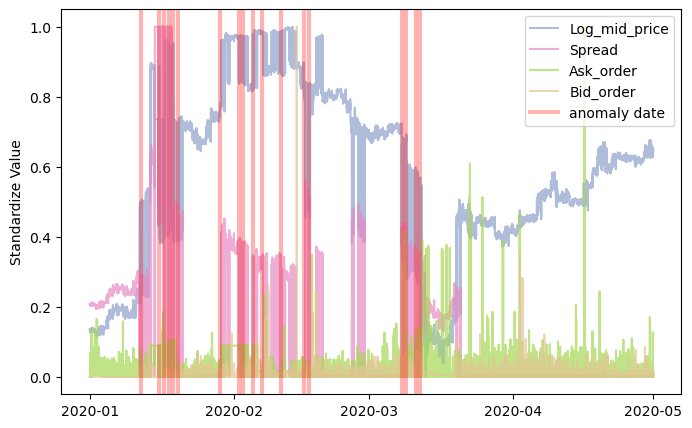

In [20]:
ZEC_trade = read_OB('ZEC',month)
ZEC_anoml_date_train,ZEC_threshold = plot_CADSig_result('ZEC',ZEC_trade,0.85)

#### LTC

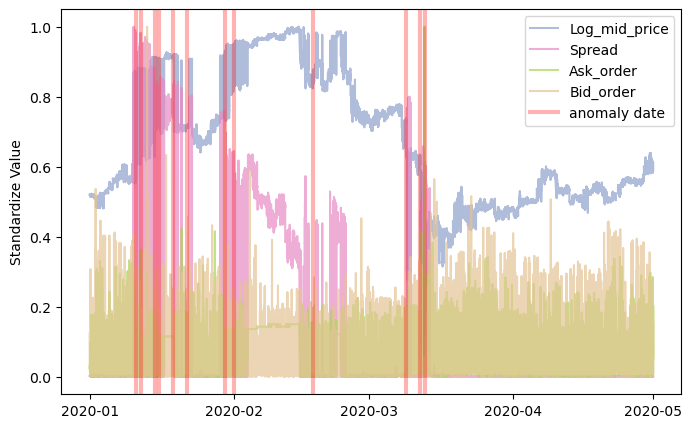

In [21]:
LTC_trade = read_OB('LTC',month)
LTC_anoml_date_train,LTC_threshold = plot_CADSig_result('LTC',LTC_trade,0.9)

#### ETH

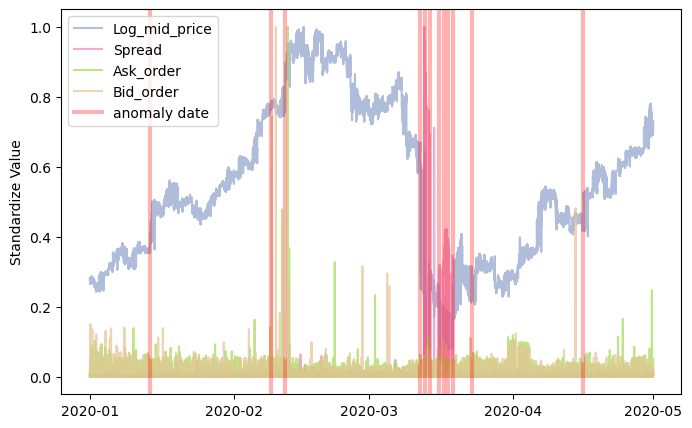

In [22]:
ETH_trade = read_OB('ETH',month)
ETH_anoml_date_train,ETH_threshold = plot_CADSig_result('ETH',ETH_trade,0.9)

#### BTC

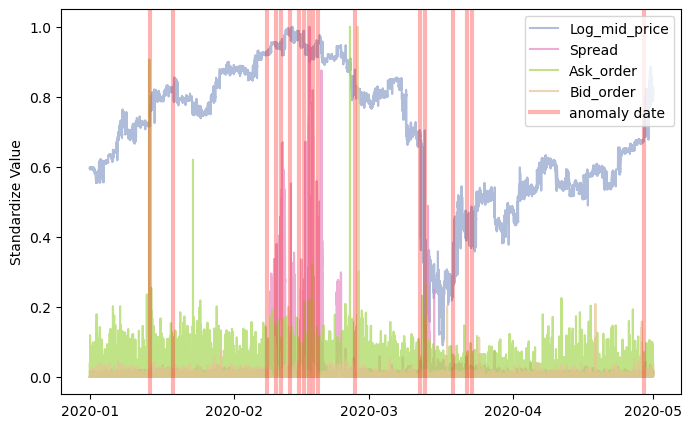

In [23]:
BTC_trade = read_OB('BTC',month)
BTC_anoml_date_train,BTC_threshold = plot_CADSig_result('BTC',BTC_trade,0.85)

### Other methods

In [24]:
def plot_knn_result(OB_raw,OB_name):
    OB_trans = create_trans_ob(creat_ob(OB_raw))
    
    min_max_scaler = MinMaxScaler()
    OB_scaled_array = min_max_scaler.fit_transform(OB_trans[['log_mid_price','spread','ask_order','bid_order','imbalance']])
    OB_scaled = pd.DataFrame(OB_scaled_array,columns=['log_mid_price','spread','ask_order','bid_order','imbalance'])
    
    # code cite from https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13
    # Create KNN classifier
    nbrs = NearestNeighbors(n_neighbors = 3)
    # Fit the classifier to the data
    X = OB_scaled[['log_mid_price','spread','imbalance']]
    nbrs.fit(X)
    distances_X, indexes_X = nbrs.kneighbors(X)
    thresh = np.quantile(distances_X.mean(axis =1),0.998)
    outlier_index_X = np.where(distances_X.mean(axis = 1) > thresh)
    outlier_values_X = OB_trans.iloc[outlier_index_X]
    
    #plot    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(OB_trans['datetime'],OB_scaled['log_mid_price'],label='Log_mid_price',color=sns.color_palette('Set2')[2],alpha =0.7)
    ax.plot(OB_trans['datetime'],OB_scaled['spread'],label='Spread',color=sns.color_palette('Set2')[3],alpha =0.7)
    ax.plot(OB_trans['datetime'],OB_scaled['ask_order'],label='Ask_order',color=sns.color_palette('Set2')[4],alpha =0.7)
    ax.plot(OB_trans['datetime'],OB_scaled['bid_order'],label='Bid_order',color =sns.color_palette('Set2')[6],alpha =0.7)
    
    for i in outlier_values_X['datetime']:
        ax.axvline(i,color = 'red',label='anomaly date',linewidth = 2,alpha =0.3)
    legend_without_duplicate_labels(ax)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_ylabel('Standardize Value')
    fig.savefig('figure/orderbook/market_{}_knn.png'.format(OB_name), dpi=300)
    
    return outlier_values_X

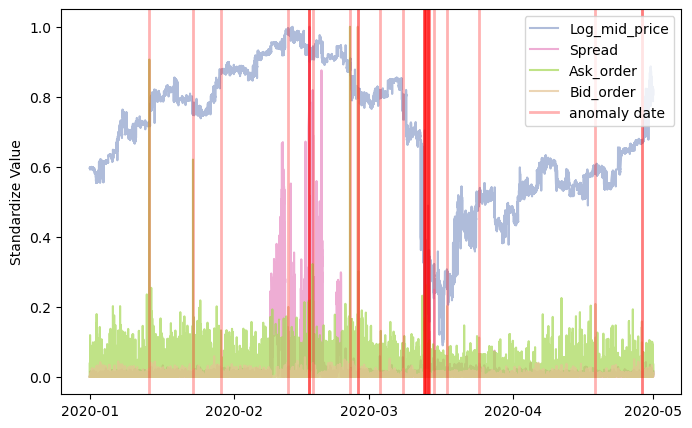

In [25]:
knn_outlier_values_BTC = plot_knn_result(BTC_trade,'BTC')

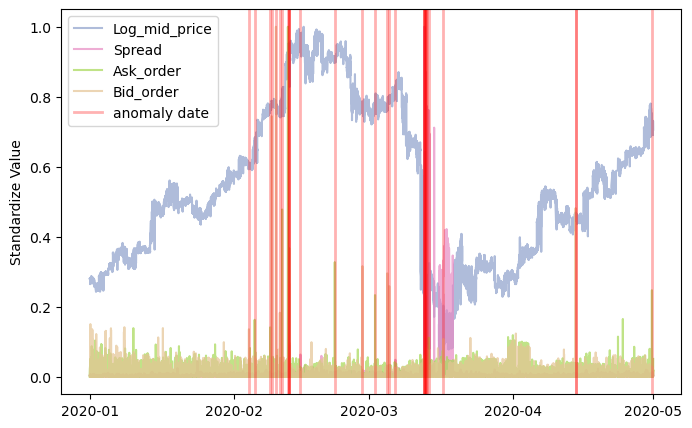

In [26]:
knn_outlier_values_LTC = plot_knn_result(ETH_trade,'ETH')

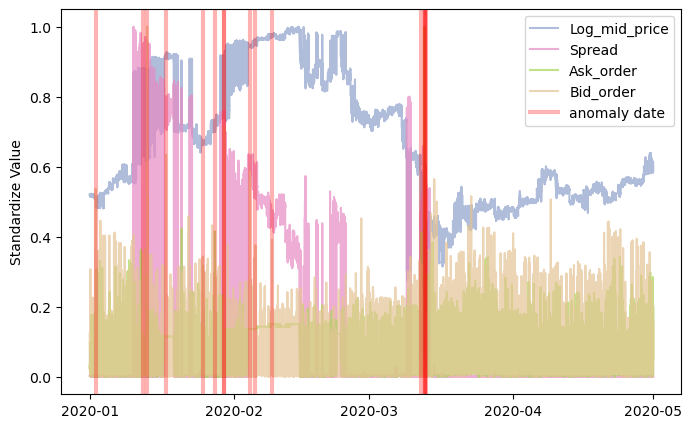

In [185]:
knn_outlier_values_LTC = plot_knn_result(LTC_trade,'LTC')